 ## Facial Image Gneration using Deep Convolutional Generative Adversarial Networks with TensorFlow

Imagine generating faces images of people who don't even exist! How exciting is that!? That's exactly what we try achieveing in this notebook.

We use Generative Adversarial Network(GAN),the latest addition to the unsupervised learning algorithm,  to build a system for the generation of realistic facial images.The model generates new faces given a set of desired facial characteristics. An image so real,you won't can't say its machine generated.

Through this notebook we try to explain how we can build such a system and how we achived qualitative results.
Lets get started!!

## How to run this notebook

* Before you can run this notebook, make sure you have **docker** and **git** installed in your machine. This is mainly to avoid burdening you to install all the softwares and dependencies required for running the notebook manually.
[See installing docker](https://docs.docker.com/install/)

### Get all the required files from the github repository
* Clone the following [repository](https://github.com/spring2018-ads/face-generation-gan) which contains all files required to run this notebook.


### Clone the repository 
* Clone the repository using the following command.

```git clone https://github.com/spring2018-ads/face-generation-gan.git```

* Once the repository is cloned, traverse to the repository in command line. (All of the below commands should be executed from this path)


### Run using: Dockerfiles (Recommended)
1) Docker will start a container with the following python libraries,
* matplotlib
* glob
* pillow
* numpy
* tensorflow

2) Build the docker image

```docker build -t ADS_<image_type> -f ./dockerfiles/Dockerfile.<image_type> ./dockerfiles/ ```

* where image_type is either gpu or cpu. (Note that, in order to run these files on your GPU, you'll need to have a compatible GPU, with drivers installed and configured properly as described in [TensorFlow's documentation](https://www.tensorflow.org/install/)

3) Run the Docker image by entering

``` docker run -it -p 8888:8888 -v <path to repository>:/root ADS_<image_type> ```

* where image_type is either gpu or cpu, depending on the image you built in the last step.

* path to repository is the location of your cloned repository.

4) After building, starting, and attaching to the appropriate Docker container, run the provided Jupyter notebooks by entering

``` jupyter notebook --ip 0.0.0.0 ```

5) navigate to http://0.0.0.0:8888 in your browser.

* Choose face-gan.ipynb to open the Notebook.

## The Dataset

The CelebFaces Attributes Dataset dataset contains over 200,000 celebrity images each with 40 attribute annotations. At this point, we are also going to define to function for batch size generation. This function will load our images and give us an array of images according to a batch size , which is a variable that can be set later.   To get some better results, we will crop the images, so that the image focuses on the face. images are normalized, so that their  pixel values are in a range from -0,5 to +0,5. We finally  downscale the images to 28x28.

Downloading celebA dataset. The helper.py contains the code to download the dataset.

In [4]:
import helper

data_dir = './data'
# Let's download the dataset
helper.download_celeb_a()

Found Celeb-A - skip


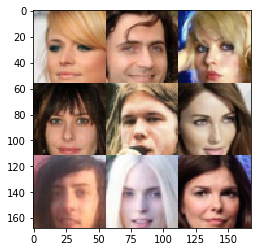

In [5]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np

# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5
        

test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(helper.images_square_grid(test_images))

A sample of our dataset.

# Architecture

In this section, we describe the proposed model for object completion. Given a set of facial images, our goal is to generate an image that is both semantically and visually realistic. Figure 2 shows the proposed network that consists of one generator, two discriminators, and a parsing network.
	Generative adversarial networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by a system of two neural networks contesting with each other in a zero-sum game framework. This was introduced by Ian Goodfellow in 2014.
	The model contains 2 deep convoluted models, one the generator that is responsible for the generation of realistic fake images. Initially the generator takes in a set of random values through probability distribution and generates an image with random pixel values. The discriminator takes in the real images from the dataset along with the fake images that are generated by the generator. The main job of the discriminator is to identify the fake images from the real images and the throughput is sent back to the generator to improve on the generated images to make it seem more realistic. This process continues till the discriminator cannot differentiate between the real and fake images. 

## Defining network input

Before we can start defining our two networks, we are going to define our inputs. Here, we are simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

In [6]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The discriminator network

The discriminator is the “art critic”, who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification. The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

![alt text](./img/discriminator.png)

The above image illustrates how the image is reshaped and resized during different layers of convolution in the generator and discriminator.

(**Note**: The filters and neurons size are not the same as the one used in the convolutional neural network in this notebook)

The discriminator is the “art critic”, who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification. The generator can be trained to create facial images with small errors. However, it does not ensure that the generated image is visually realistic and coherent.

The generated pixels are quite blurry and only capture the coarse shape of the face components. To encourage more photorealistic results, we adopt a discriminator D that serves as a binary classifier to distinguish between real and fake images. 

The goal of this discriminator is to help improve the quality of synthesized results such that the trained discriminator is fooled by unrealistic images. The fundamental idea is that the newly generated contents should not only be realistic, but also consistent to the surrounding contexts.
        
The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu
        
*Now moving to understanding the actual code*,the first 3 layers are defiened as a convolution with filter size, 64 128, and 256 and stride of 2,2,1 and kernel size of 5.

After each convolution the leaky relu is applied(max of the pervious output and it's product with alpha).

logits layer gives the score of each feature obtained in the image and the sigmoid of the logit layer gives us the prediction of features with values between 0 and 1.

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

## The generator network

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.
![alt text](./img/generator.png)

The above image illustrates how the image is reshaped and resized during different layers of convolution in the generator.

(**Note**: The filters and neurons size are not the same as the one used in the network architecture in this notebook)
 
 The code of the generator does the reverse of what discriminator does. The generator initially starts with a noise instead of features.
 
 The 100z (z-dimension) is the initial noise, which serves as an input to the initial layer of 2048 neurons.
 
 Followed by the initial dense layer is reshaped (kernel=2, stride=2, filter=512) to serve as input for the first of the two layers.
 
 Batch normalization between each layer helps reducing unit variance and accomodate faster learning rate.
 
 finally the output of the first layer(kernel=5, stride=2, filter=256) is batch normalized and sent as input for the second layer.
 
 The final layer of the generator generates the pixels of the image.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

## Loss Functions

The loss of each of the model is used to train the overal model to generate better results,optimize the model. Rather than just having a single loss function, we define three: 
* The loss of the generator,
* the loss of the discriminator when using real images and
* the loss of the discriminator when using fake images.

The sum of the fake image and real image loss is the overall discriminator loss.The model tries to minimize both these losses.

Here is the scary mathematical funtion for the  total loss function 

 ```min GmaxDV(D,G)=Ex∼pdata(x)[logD(x)]+Ez∼pz(z)[log(1−D(G(z)))]```

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    """The label smoothing is used as a regularization technique"""
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

## Optimization

The The optimization algorithm continously upadates the weights and baises of the model.Think of this to be similar to the feedback an employee gets that helps him better every cycle. On similar lines, the model learns from its losses and adjusts it's biases and weights that define the model.We used Adamoptimiser in this network.

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization 
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Visualization

In the last step of our preparation, we are write a small helper function to display the generated images in the notebook for us, using the matplotlib library.This is more so vital,in this case as the visual images are the only means for us to evaluate the model. The better clarity of image, the better the model has performed.

In [11]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

## Training

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 400 steps we are printing out the current progress by showing the generated image and loss. Now lean back and see the faces show up slowly but steady. This progress can take up some hours based on your setup.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 25, input_z, data_shape[3],'RGB')


# Conclusion and Results

The model with hyper-parameters(parameters that determine the network structure) as defined below, it generates images. These hyperparameter have been changed and experimented with and finally found these to be giving the best results. These are the first set of images that are generated by the model. The model eventually generates(after multiple epochs) better looking images.  

Epoch 3/5... Discriminator Loss: 1.2189... Generator Loss: 0.8536


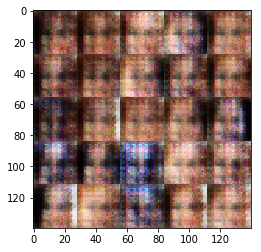

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 5

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

## Citations and references

We referred several blogs and papers. One of the most prominent blogs that helped us get a better understanding of the Generative Adverserial Network is the O’Reilly DCGAN Implementation and tensorflow [tutorial](https://www.tensorflow.org/tutorials/layers) for CNN.

### References:
* [1](http://papers.nips.cc/paper/5423-generative-adversarial-nets) Goodfellow, Ian, et al. “Generative adversarial nets.” Advances in Neural Information Processing Systems. 2014.
* [2](http://papers.nips.cc/paper/5773-deep-generative-image-models-using-a-5) Denton, Emily, et al. “Deep Generative Image Models using a Laplacian Pyramid of Adversarial Networks.” arXiv preprint arXiv:1506.05751 (2015).
* [3](https://arxiv.org/abs/1312.6114) Kingma, Diederik P., and Max Welling. “Auto-encoding variational bayes.” arXiv preprint arXiv:1312.6114 (2013).
* [4](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton “ImageNet Classification with Deep Convolutional Neural Networks.” arXiv preprint arXiv:1312.6114 (2013).
* [5](https://arxiv.org/abs/1502.04623) DRAW: A Recurrent Neural Network For Image Generation Karol Gregor, Ivo Danihelka, Alex Graves, Danilo Jimenez Rezende, Daan Wierstra
* [6](https://ieeexplore.ieee.org/abstract/document/655647/)Neural network-based face detection Henry A. Rowley, Student Member, IEEE, Shumeet Baluja, and Takeo Kanade, Fellow, IEEE
* [7](https://ieeexplore.ieee.org/abstract/document/554195/) Face Recognition: A Convolutional Neural-Network Approach Steve Lawrence, Member, IEEE, C. Lee Giles, Senior Member, IEEE, Ah Chung Tsoi, Senior Member, IEEE,and Andrew D. Back, Member, IEEE
* [8](http://science.sciencemag.org/content/313/5786/504) Reducing the Dimensionality of Data with Neural Networks by G. E. Hinton and R. R. Salakhutdinov
* [9](https://github.com/dmonn/dcgan-oreilly) O’Reilly DCGAN Documentation


#### Copyright © 2018 Ajjunesh Raju, Shivani Udupa, Vikram Ramesh

The code in the document by Ajjunesh Raju, Shivani Udupa, Vikram Ramesh is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The code in the document by Ajjunesh Raju, Shivani Udupa, Vikram Ramesh is licensed under the MIT License https://opensource.org/licenses/MIT

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.